# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:20<00:00, 2225.90it/s]


In [18]:
preprocessed_reviews[15001]

'suppose splitting hairs define cane syrup product contains pure cane sugar water perhaps bit preservative qualifies called pure cane syrup really simple sugar syrup made water pure cane sugar could make home buy already made ready use'

# [4] Featurization

## [4.1] BAG OF WORDS

In [18]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [19]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


## [5.1] Applying KNN brute force

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
scores = final['Score']
x_1, x_test, y_1, y_test = train_test_split(preprocessed_reviews[0:20000], scores[0:20000], test_size = 0.3)
x_tr, x_cv,y_tr,y_cv = train_test_split(x_1, y_1, test_size = 0.3)
print(len(x_tr),len(y_tr))
print(len(x_cv),len(y_cv))
print(len(x_test),len(y_test))

9800 9800
4200 4200
6000 6000


In [44]:
from tqdm import tqdm

def hyperparameter(x_train,x_cross, algo):
    cv_scores=[] #list to store cross validation scores
    train_scores = []
    for k in tqdm(range(1,100,4)):
        knn = KNeighborsClassifier(n_neighbors = k, n_jobs=-1, algorithm =algo,metric = "cosine") #initialising model
        knn.fit(x_train,y_tr)
        cv_proba = knn.predict_proba(x_cross)
        cv_score = roc_auc_score(y_cv,cv_proba[:,1])
        train_proba = knn.predict_proba(x_train)
        train_score = roc_auc_score(y_tr,train_proba[:,1])
        
        train_scores.append(train_score) 
        cv_scores.append(cv_score)

    
    neighbors = list(range(1,100,4))
    optimal_k = neighbors[cv_scores.index(max(cv_scores))]# determining optimal k
    
    sns.set_style("whitegrid")
    plt.plot(neighbors, cv_scores, label = "Cross Validation data AUC Scores") #plotting error plot
    plt.plot(neighbors, train_scores, label = "Training data AUC Scores")
    plt.xlabel('number of neighbors k')
    plt.ylabel('AUC Scores')
    plt.legend()
    plt.show()
    print("optimal k is ", optimal_k)
    
    return optimal_k    

In [45]:
print(len(x_tr))
print(len(x_cv))
print(len(x_test))

9800
4200
6000


### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

count_vec = CountVectorizer(min_df = 10) #intialising CountVectorizer
train_bow = count_vec.fit_transform(x_tr)
cv_bow = count_vec.transform(x_cv)
test_bow = count_vec.transform(x_test)
train_bow = csr_matrix.todense(train_bow)
cv_bow = csr_matrix.todense(cv_bow)
test_bow = csr_matrix.todense(test_bow)
print(type(train_bow))

<class 'numpy.matrix'>


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [09:03<00:00, 41.84s/it]


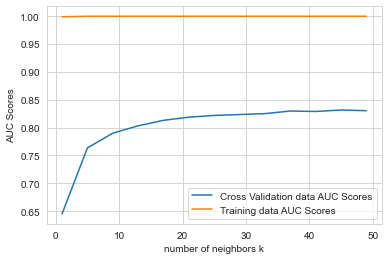

optimal k is  45
 test roc auc =  0.8412588263422902


In [36]:
k = hyperparameter(train_bow,cv_bow, 'brute')
knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='brute',metric= 'cosine',weights = 'distance')
knn.fit(train_bow, y_tr)
pred = knn.predict(test_bow)
pred_prob = knn.predict_proba(test_bow)
print(' test roc auc = ', roc_auc_score(y_test, pred_prob[:,1]))

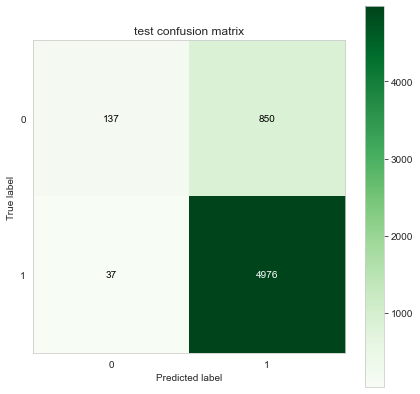

In [37]:
import scikitplot.metrics as skplt 
skplt.plot_confusion_matrix(y_test, pred, cmap = "Greens", figsize = (7,7))
plt.title("test confusion matrix")
plt.show()

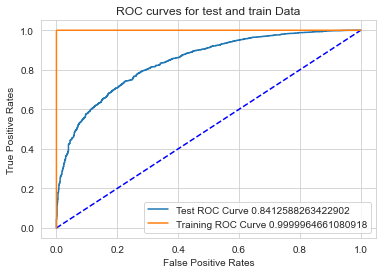

In [38]:
#plotting ROC Curves
pred_prob = knn.predict_proba(test_bow)
pred_train_prob = knn.predict_proba(train_bow)
train_roc = roc_auc_score(y_tr, pred_train_prob[:,1])
test_roc = roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:,1])
fpr1 ,tpr1, thresholds = roc_curve(y_tr, pred_train_prob[:,1])

plt.plot([0,1],[0,1],'b--')
plt.plot(fpr,tpr, label = "Test ROC Curve "+ str(test_roc))
plt.plot(fpr1,tpr1,label = "Training ROC Curve " + str(train_roc))
plt.legend()
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curves for test and train Data")
plt.show()


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [24:08<00:00, 57.95s/it]


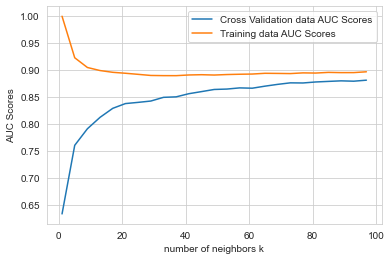

optimal k is  97
 test roc auc =  0.8866227443904208


In [46]:

tfidf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 10, max_features = 50000) #intialising CountVectorizer
train_tfidf = tfidf_vect.fit_transform(x_tr)
test_tfidf = tfidf_vect.transform(x_test)
cv_tfidf = tfidf_vect.transform(x_cv)

train_tfdif = csr_matrix.todense(train_tfidf)
cv_tfidf = csr_matrix.todense(cv_tfidf)
test_tfidf = csr_matrix.todense(test_tfidf)


k = hyperparameter(train_tfdif,cv_tfidf, 'brute')
knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='brute',metric = 'cosine',weights = 'distance')
knn.fit(train_tfidf, y_tr)
pred_tfdif = knn.predict(test_tfidf)
pred_proba = knn.predict_proba(test_tfdif)
print(' test roc auc = ', roc_auc_score(y_test, pred_proba[:,1]))

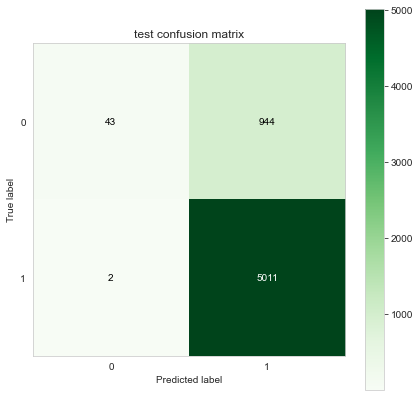

In [47]:
skplt.plot_confusion_matrix(y_test, pred_tfdif, cmap = "Greens", figsize = (7,7))
plt.title("test confusion matrix")
plt.show()

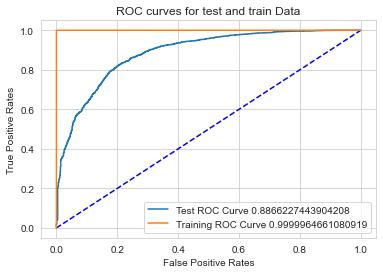

In [49]:
pred_prob = knn.predict_proba(test_tfidf)
pred_train_prob = knn.predict_proba(train_tfidf)
train_roc = roc_auc_score(y_tr, pred_train_prob[:,1])
test_roc = roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:,1])
fpr1 ,tpr1, thresholds = roc_curve(y_tr, pred_train_prob[:,1])

plt.plot([0,1],[0,1],'b--')
plt.plot(fpr,tpr, label = "Test ROC Curve "+ str(test_roc))
plt.plot(fpr1,tpr1,label = "Training ROC Curve " + str(train_roc))
plt.legend()
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curves for test and train Data")
plt.show()


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [53]:
from gensim.models import Word2Vec
list_of_sentance = []
for sentance in x_tr:
    list_of_sentance.append(sentance.split())

w2v_model = Word2Vec(list_of_sentance, size = 50, workers = -1)
print(list(w2v_model.wv.vocab)[0:50])

['used', 'use', 'coffee', 'visited', 'costa', 'rica', 'gave', 'aunt', 'thinks', 'best', 'christmas', 'excellent', 'daughter', 'loves', 'crackers', 'peanut', 'butter', 'come', 'two', 'small', 'packages', 'inside', 'box', 'good', 'not', 'eat', 'wheat', 'gluten', 'allergies', 'product', 'contain', 'soy', 'eggs', 'milk', 'sesame', 'great', 'cracker', 'least', 'according', 'year', 'old', 'never', 'really', 'know', 'products', 'taste', 'like', 'loved', 'jello', 'since']


In [54]:
def avgw2v(lst):
    list_of_sentance = []
    for sentance in lst:
        list_of_sentance.append(sentance.split())
    sentance_vect = []
    for sentance in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        count = 0
        for word in sentance:
            if word in list(w2v_model.wv.vocab):
                sent_vec+= w2v_model.wv[word]
                count+=1
        if count!=0:
            sent_vec/=count
        sentance_vect.append(sent_vec)

    return(sentance_vect)
                
        
        

In [55]:
train_avgw2v = avgw2v(x_tr)
cv_avgw2v = avgw2v(x_cv)
test_avgw2v = avgw2v(x_test)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:20<00:00, 286.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:23<00:00,  5.74s/it]


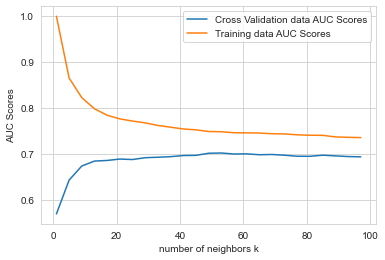

optimal k is  53
 test roc auc =  0.7358481928748173


In [65]:
k = hyperparameter(train_avgw2v,cv_avgw2v, 'brute')
knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute', n_jobs = -1, metric = 'cosine')
knn.fit(train_avgw2v, y_tr)
pred = knn.predict(test_avgw2v)
pred_proba = knn.predict_proba(test_avgw2v)
print(' test roc auc = ', roc_auc_score(y_test, pred_proba[:,1]))

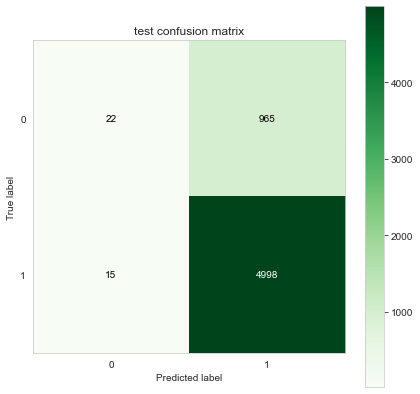

In [66]:
skplt.plot_confusion_matrix(y_test, pred, cmap = "Greens", figsize = (7,7))
plt.title("test confusion matrix")
plt.show()

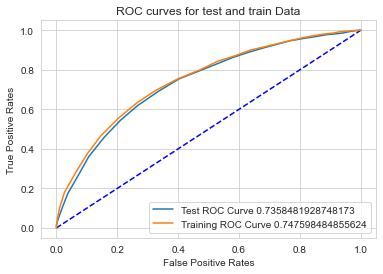

In [69]:
pred_prob = knn.predict_proba(test_avgw2v)
pred_train_prob = knn.predict_proba(train_avgw2v)
train_roc = roc_auc_score(y_tr, pred_train_prob[:,1])
test_roc = roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:,1])
fpr1 ,tpr1, thresholds = roc_curve(y_tr, pred_train_prob[:,1])

plt.plot([0,1],[0,1],'b--')
plt.plot(fpr,tpr, label = "Test ROC Curve "+ str(test_roc))
plt.plot(fpr1,tpr1,label = "Training ROC Curve " + str(train_roc))
plt.legend()
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curves for test and train Data")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [74]:
model = tfidf_vect.fit_transform(x_tr)
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tf_idf_feat = tfidf_vect.get_feature_names()

In [75]:
def tfidf_w2v(lst):
    list_of_sentance = []
    for sent in lst:
        list_of_sentance.append(sent.split())
        
    tfidf_sent_vector = []
    row = 0
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        count = 0
        for word in sent:
            if word in list(w2v_model.wv.vocab) and word in tf_idf_feat:
                vec = w2v_model.wv[word]
                tfidf_vec = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (tfidf_vec*vec)
                count+=tfidf_vec
            if count!= 0:
                sent_vec/= count
        tfidf_sent_vector.append(sent_vec)
    return tfidf_sent_vector      

In [76]:
train_tfidf_w2v = tfidf_w2v(x_tr)
cv_tfidf_w2v = tfidf_w2v(x_cv)
test_tfidf_w2v = tfidf_w2v(x_test)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:48<00:00, 122.55it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:13<00:00,  7.75s/it]


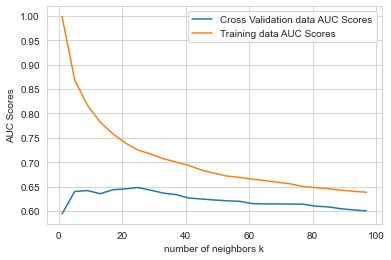

optimal k is  25
 test roc auc =  0.6582293332169188


In [79]:
k = hyperparameter(train_tfidf_w2v,cv_tfidf_w2v, 'brute')
knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute', n_jobs = -1, metric = 'cosine')
knn.fit(train_tfidf_w2v, y_tr)
pred = knn.predict(test_tfidf_w2v)
pred_proba = knn.predict_proba(test_tfidf_w2v)
print(' test roc auc = ', roc_auc_score(y_test, pred_proba[:,1]))

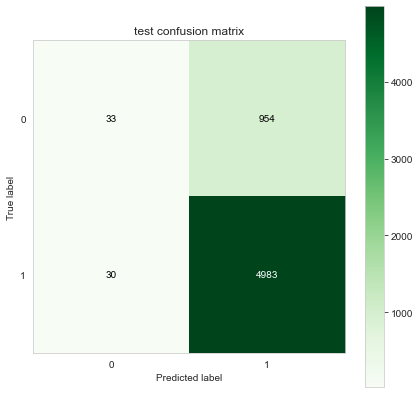

In [80]:
skplt.plot_confusion_matrix(y_test, pred, cmap = "Greens", figsize = (7,7))
plt.title("test confusion matrix")
plt.show()

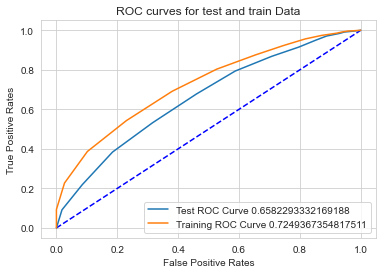

In [81]:
pred_prob = knn.predict_proba(test_tfidf_w2v)
pred_train_prob = knn.predict_proba(train_tfidf_w2v)
train_roc = roc_auc_score(y_tr, pred_train_prob[:,1])
test_roc = roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:,1])
fpr1 ,tpr1, thresholds = roc_curve(y_tr, pred_train_prob[:,1])

plt.plot([0,1],[0,1],'b--')
plt.plot(fpr,tpr, label = "Test ROC Curve "+ str(test_roc))
plt.plot(fpr1,tpr1,label = "Training ROC Curve " + str(train_roc))
plt.legend()
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curves for test and train Data")
plt.show()

# [6] Conclusions

In [86]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectorizer", "Algorithm", "Optimal_k", "Test AUC Score"]
table.add_row(["Bag of Words", "Brute KNN",45,0.8412588263422902])
table.add_row(["TF-IDF", "Brute KNN",97,0.8866227443904208])
table.add_row(['Average Word2Vec', "Brute KNN",53,0.7358481928748173])
table.add_row(["TF-IDF Weighted Word2Vec", "Brute KNN",25,0.6582293332169188])
print(table)

+--------------------------+-----------+-----------+--------------------+
|        Vectorizer        | Algorithm | Optimal_k |   Test AUC Score   |
+--------------------------+-----------+-----------+--------------------+
|       Bag of Words       | Brute KNN |     45    | 0.8412588263422902 |
|          TF-IDF          | Brute KNN |     97    | 0.8866227443904208 |
|     Average Word2Vec     | Brute KNN |     53    | 0.7358481928748173 |
| TF-IDF Weighted Word2Vec | Brute KNN |     25    | 0.6582293332169188 |
+--------------------------+-----------+-----------+--------------------+
